<a href="https://colab.research.google.com/github/HuangJin-De/Machine-Learning-in-Atmospheric-Thermodynamics/blob/main/hw01/hw01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# test whether torch is available
# if not, you could apply GPU by turn on it in Edit->Notebook Settings in the control bar
torch.cuda.is_available()


True

In [3]:
# download data from Fashion-Mnist website
train_data=datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
test_data=datasets.FashionMNIST(root="data",train=False,download=True,transform=ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



torch.Size([64, 1, 28, 28])
torch.Size([64])


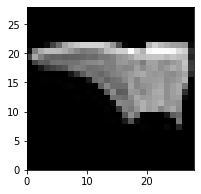

In [4]:
batch_size=64

# dataloader
train_loader=DataLoader(train_data,batch_size=batch_size)
test_loader=DataLoader(test_data,batch_size=batch_size)

# test and plot data
for X, y in test_loader:
  print(X.shape)
  print(y.shape)
  fig, ax = plt.subplots(figsize=(3,3))
  c = plt.pcolor(X[0,0,:,:],cmap='gray')
  break

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()  
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),   
            nn.ReLU(),           
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)       
        loss = loss_fn(pred, y) 

        optimizer.zero_grad()  
        loss.backward()      
        optimizer.step()      
       
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    num_batches = len(dataloader)

    model.eval()

    test_loss, correct = 0, 0

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)

            test_loss += loss_fn(pred, y).item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.314094  [    0/60000]
loss: 2.293878  [ 6400/60000]
loss: 2.278123  [12800/60000]
loss: 2.273237  [19200/60000]
loss: 2.259146  [25600/60000]
loss: 2.226884  [32000/60000]
loss: 2.239897  [38400/60000]
loss: 2.208172  [44800/60000]
loss: 2.202324  [51200/60000]
loss: 2.165126  [57600/60000]
Test Error: 
 Accuracy: 32.5%, Avg loss: 2.166701 

Epoch 2
-------------------------------
loss: 2.178045  [    0/60000]
loss: 2.161041  [ 6400/60000]
loss: 2.108784  [12800/60000]
loss: 2.127210  [19200/60000]
loss: 2.075958  [25600/60000]
loss: 2.017284  [32000/60000]
loss: 2.046850  [38400/60000]
loss: 1.972123  [44800/60000]
loss: 1.978747  [51200/60000]
loss: 1.898025  [57600/60000]
Test Error: 
 Accuracy: 52.8%, Avg loss: 1.906608 

Epoch 3
-------------------------------
loss: 1.942450  [    0/60000]
loss: 1.901463  [ 6400/60000]
loss: 1.797314  [12800/60000]
loss: 1.838222  [19200/60000]
loss: 1.723407  [25600/60000]
loss: 1.683708  [32000/600

# 新增區段